In [1]:
cd /content/drive/MyDrive/Project III/img(romance)

/content/drive/MyDrive/Project III/img(romance)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import PIL.Image
import random 
import os
import glob

from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
import glob
from glob import glob

data_list = glob('./*.jpg')
data_list[:5]

['./달콤 살벌한 부부 [독점].jpg',
 './매일10시무료텐 나잇(ten night) [선공개].jpg',
 './불순한 짓 [선공개] (1).jpg',
 './매일10시무료전남편의 덫 [선공개].jpg',
 './천월서금 [독점].jpg']

In [4]:
len(data_list)

881

In [5]:
data_list[10]

'./매일10시무료속박 결혼.jpg'

### 이미지 전처리해야할 것 
- crop
- resize
- convert (grayscale or color)
- invert (if necessary)
- scaling (/255 -> 0-1사이 값)
- reshape 

(173, 254)


(254, 173, 3)

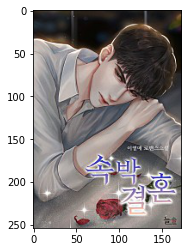

In [6]:
# PIL 사용하기 
from PIL import Image

img = Image.open(data_list[10])
plt.imshow(img)
np.array(img)

# 이미지 사이즈 
print(img.size)
np.shape(img)

(160, 160, 3)

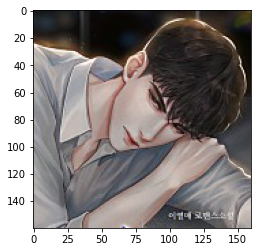

In [7]:
# image.crop(startLeft, startUp, endRight, endDown)
croppedImg = img.crop((10,10,170,170))  #이 위치를 어떻게 하지? 음.. 
plt.imshow(croppedImg)
np.shape(croppedImg)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
       0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
       0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
       0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
       0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25098039,
       0.25490196, 0.25882353, 0.2627451 , 0.26666667, 0.27058824,
       0.2745098 , 0.27843137, 0.28235294, 0.28627451, 0.29019

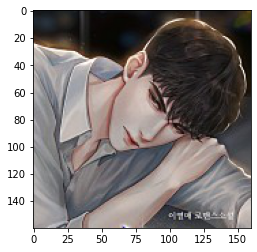

In [8]:
# 0-1, scaling
scaledImg = np.array(croppedImg)/255
plt.imshow(np.array(scaledImg))
np.unique(scaledImg)

In [9]:
# 1차원 배열로 전환 

----

## open cv 이용해서 외곽따기 
- [참고링크](https://youbidan.tistory.com/19)

In [10]:
import cv2, sys
from matplotlib import pyplot as plt
import numpy as np

In [11]:
imgfile = glob('./*.jpg')

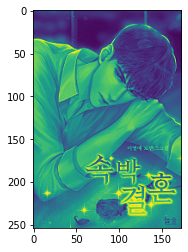

In [12]:
# 파일 불러오고 grayscale로 바꿈 
image = cv2.imread(imgfile[10])
image_gray = cv2.imread(imgfile[10], cv2.IMREAD_GRAYSCALE)
plt.imshow(image_gray)

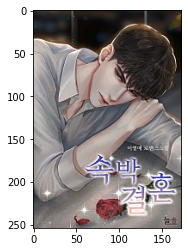

In [13]:
# r,g,b 순서대로 담기 
b,g,r = cv2.split(image)
image2 = cv2.merge([r,g,b])

plt.imshow(image2)

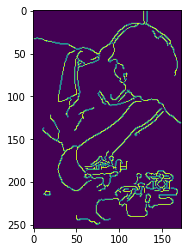

In [14]:
# 객체만 따오기(가우시안 블러 사용)
blur = cv2.GaussianBlur(image_gray, ksize=(7,7), sigmaX=0)  #ksize는 조절하기!(홀수만 되는듯)
ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)

edged = cv2.Canny(blur, 10, 250)    #cv2.Canny: 모서리 찾기
plt.imshow(edged)

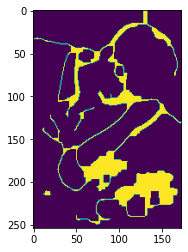

In [15]:
#엣지이미지로 closed 찾기 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed)

In [16]:
# 컨투어 경계 찾기 
contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total=0

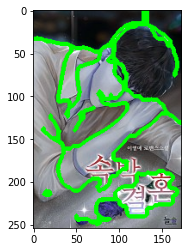

In [17]:
# 원래 이미지에 외곽선 그려보기 
contours_image = cv2.drawContours(image, contours, -1, (0,255,0), 3)
plt.imshow(contours_image)

In [18]:
contours_xy = np.array(contours)
contours_xy.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(4,)

바로 위 행의 결과 
- contours[] => 물체가 몇 개인지 나타냅니다. 하나의 닫힌 선이 물체 하나를 인식합니다. 

- contours[][] => 이 때부터 각 좌표를 나타냅니다

- contours[][][x][y] -> 세번째와 네번째 부터는 각각 x축과 y축

In [19]:
# x의 min과 max 찾기
x_min, x_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
        x_min = min(value)
        x_max = max(value)
print(x_min)
print(x_max)
 
# y의 min과 max 찾기
y_min, y_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
        y_min = min(value)
        y_max = max(value)
print(y_min)
print(y_max)


0
172
0
249


In [20]:
# image trim 하기
x = x_min
y = y_min
w = x_max-x_min
h = y_max-y_min

In [21]:
img_trim = image[y:y+h, x:x+w]
cv2.imwrite('org_trim.jpg', img_trim)
org_image = cv2.imread('org_trim.jpg')

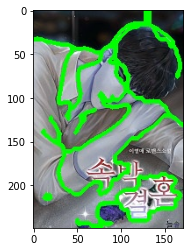

In [22]:
plt.imshow(org_image)

- 위의 cropped로 해볼까

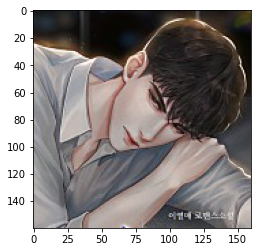

In [25]:
plt.imshow(croppedImg)

In [32]:
croppedImg.save('./00.cropped.jpg', 'jpeg')

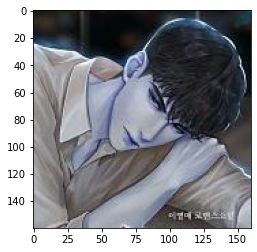

In [33]:
img2 = cv2.imread('./00.cropped.jpg')
img2_gray = cv2.imread('./00.cropped.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img2)

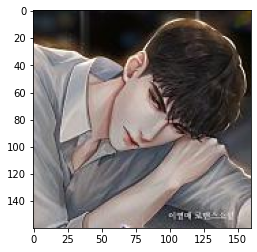

In [34]:
# r,g,b 순서대로 담기 
b,g,r = cv2.split(img2)
image3 = cv2.merge([r,g,b])

plt.imshow(image3)

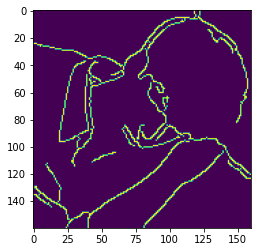

In [36]:
# 객체만 따오기(가우시안 블러 사용)
blur = cv2.GaussianBlur(img2_gray, ksize=(7,7), sigmaX=0)  #ksize는 조절하기!(홀수만 되는듯)
ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)

edged = cv2.Canny(blur, 10, 250)    #cv2.Canny: 모서리 찾기
plt.imshow(edged)

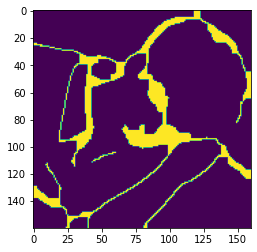

In [37]:
#엣지이미지로 closed 찾기 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed)

In [38]:
# 컨투어 경계 찾기 
contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total=0

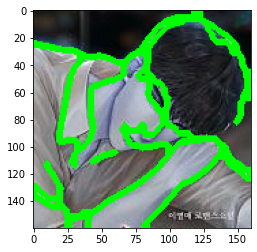

In [40]:
# 원래 이미지에 외곽선 그려보기 
contours_img2 = cv2.drawContours(img2, contours, -1, (0,255,0), 3)
plt.imshow(contours_img2)

In [41]:
contours_xy = np.array(contours)
contours_xy.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(2,)

In [42]:
# x의 min과 max 찾기
x_min, x_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
        x_min = min(value)
        x_max = max(value)
print(x_min)
print(x_max)
 
# y의 min과 max 찾기
y_min, y_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
        y_min = min(value)
        y_max = max(value)
print(y_min)
print(y_max)

0
159
0
159


In [43]:
# image trim 하기
x = x_min
y = y_min
w = x_max-x_min
h = y_max-y_min

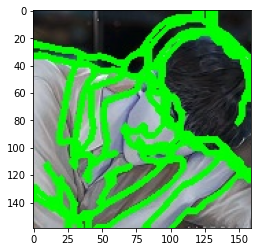

In [45]:
img_trim = image[y:y+h, x:x+w]
cv2.imwrite('org_trim.jpg', img_trim)
org_img2 = cv2.imread('org_trim.jpg')

plt.imshow(org_img2)